HHU Deep Learning, SS2024, 10.05.2024, Prof. Dr. Markus Kollmann

Lecturers and Tutoring is done by Nikolas Adaloglou and Felix Michels.

# Assignment 04 - Contrastive self-supervised learning: SimCLR in STL10 with Resnet18 
---

Submit the solved notebook (not a zip) with your full name plus assignment number for the filename as an indicator, e.g `max_mustermann_a1.ipynb` for assignment 1. If we feel like you have genuinely tried to solve the exercise, you will receive 1 point for this assignment, regardless of the quality of your solution.

## <center> DUE FRIDAY 17.05.2024 2:30 pm </center>

Drop-off link: [https://uni-duesseldorf.sciebo.de/s/p7StWMU5ylwn2pU](https://uni-duesseldorf.sciebo.de/s/p7StWMU5ylwn2pU)

---


# Introduction 

Contrastive loss is a way of training a machine learning model in a self-supervised manner, where the goal is to learn meaningful representations of the input data without any explicit labels or annotations.

The basic idea is to take a pair of input samples (such as two augmented views from the same image), and compare them to see if they are similar or dissimilar. The model is then trained to push similar pairs closer together in the representation space, while pushing dissimilar pairs farther apart.

To do this, the contrastive loss function measures the similarity between the representations of the two input samples (nominator), and encourages the model to maximize this similarity if the samples are similar, and minimize it if they are dissimilar.


You can also advice the [SimCLR Paper](https://arxiv.org/abs/2002.05709)





### Imports, basic utils, augmentations

In [ ]:
!wget -nc https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week04/utils.py

In [22]:
import torch
import torchvision.models as models
import numpy as np
import os
import torch
import torchvision
import torchvision.transforms as T
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import STL10
from torch.utils.data import DataLoader
from torch.optim import Adam
from tqdm.notebook import trange, tqdm

# Local imports
from utils import save_model, load_model, linear_eval, \
    tsne_plot_embeddings, reproducibility, define_param_groups, \
    get_features

# Task 1: Implement the augmentation pipeline used in SimCLR


In contrastive self-supervised learning, there are several image augmentations that are commonly used to create pairs of images that are transformed versions of each other. These augmentations are designed to ensure that the resulting views have enough differences between them so that the model can learn to distinguish between them, while also preserving the label-related information.

Some of the commonly used image augmentations in contrastive self-supervised learning include in **random order**:


- Random flipping: This involves randomly flipping the image horizontally or vertically. Choose the one that best fits with a probability of 50%.
- Normalize the images with an appropriate mean std.
- Color jitter: This involves randomly changing the brightness, contrast, saturation and hue (20%) of the image. This augmentation helps the model learn to recognize objects or scenes under different lighting conditions. Apply this augmentation with a probability of 80%. Distort the brightness, contrast, saturation in the range `[0.2, 1.8]`.
- Random cropping: This involves randomly cropping a portion of the image to create a new image. We will then resize the images to 64x64 instead of 96x96 to reduce the computational time complexity to train the model.  Use a scale of 10-100% of the initial image size. 
- Gaussian blur: This augmentation helps the model learn to recognize objects or scenes that are slightly out of focus. Use a `kernel_size` of 3 and Standard deviation of 0.1 to 2.0.


The above augmentations are typically applied randomly to each image in a pair, resulting in two slightly different versions of the same image that can be used for contrastive learning.

Your task is to define the augmentation and decide in which order they should be applied. 

In [2]:
class Augment:
    """
    A stochastic data augmentation module
    Transforms any given data example randomly
    resulting in two correlated views of the same example,
    denoted x ̃i and x ̃j, which we consider as a positive pair.
    """
    def __init__(self, img_size):
        ### START CODE HERE ###
        color_jitter = T.ColorJitter(
            0.8, 0.8, 0.8, 0.2
        )
        # 10% of the image
        blur = T.GaussianBlur((3, 3), (0.1, 2.0))

        self.train_transform = T.Compose([
            T.ToTensor(),
            T.RandomResizedCrop(scale=(0.1, 1), size=img_size),
            T.RandomHorizontalFlip(p=0.5),  # with 0.5 probability
            T.RandomApply([color_jitter], p=0.8),
            T.RandomApply([blur], p=0.5),
            T.RandomGrayscale(p=0.2),
            # imagenet stats
            T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])            
        ])
    def __call__(self, x):
        # This function applied the same transformation to an image twice.
        return self.train_transform(x), self.train_transform(x)
    ### END CODE HERE ###

def load_data( batch_size=128, train_split="unlabeled", test_split="test", transf = T.ToTensor()):
    # Returns a train and validation dataloader for STL10 dataset
    ### START CODE HERE ### (≈ 6 lines of code)
    train_ds = torchvision.datasets.STL10(root='~/data', split=train_split, transform=transf, download=True)
    val_ds = torchvision.datasets.STL10(root='~/data', split=test_split, transform=transf, download=True)
    train_dl = DataLoader(dataset=train_ds, batch_size=batch_size, num_workers=2, drop_last=True)
    val_dl = DataLoader(dataset=val_ds, batch_size=batch_size, num_workers=2, drop_last=True)
    ### END CODE HERE ###
    return train_dl, val_dl

## Task 2: Implement the SimCLR Contrastive loss (NT-Xent)

Let $sim(u,v)$ note the dot product between 2 normalized $u$ and $v$ (i.e. cosine similarity). Then the loss function for a **positive pair**
of examples (i,j) is defined as:
$$
\ell_{i, j}=-\log \frac{\exp \left(\operatorname{sim}\left(\boldsymbol{z}_{i}, \boldsymbol{z}_{j}\right) / \tau\right)}{\sum_{k=1}^{2 N} \mathbb{1}_{[k \neq i]} \exp \left(\operatorname{sim}\left(\boldsymbol{z}_{i}, \boldsymbol{z}_{k}\right) / \tau\right)}
$$

where $\mathbb{1}_{[k \neq i]} $ ∈{0,1} is an indicator function evaluating to 1 iff $k != i$ and τ denotes a temperature parameter. The final loss is computed by summing all positive pairs and divide by $2\times N = views \times batch_{size} $

There are different ways to develop contrastive loss. 


#### Hints
Here we provide you with some hints about the main algorithm:

- apply l2 normalization to the features and concatenate them in the batch dimension

- Calculate the similarity/logits of all pairs.  Output shape:[batch_size $\times$ views,batch_size $\times$ views]

- Make Identity matrix as mask with size=(batch_size $\times$ views, batch_size $\times$ views)

- Repeat the mask in both direction to the number of views (in simclr number of views = 2)
for batch_size=5 and 2 views: 
```
[1., 0., 0., 0., 0., 1., 0., 0., 0., 0.]
[0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
[0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.],
[1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
[0., 1., 0., 0., 0., 0., 1., 0., 0., 0.],
[0., 0., 1., 0., 0., 0., 0., 1., 0., 0.],
[0., 0., 0., 1., 0., 0., 0., 0., 1., 0.],
[0., 0., 0., 0., 1., 0., 0., 0., 0., 1.]
```

4. Make a mask to index the positive pairs. mask-out the self-contrast as follows.
make a mask with the shape of the logits = [batch_size $\times$ views,batch_size $\times$ views]  that has ones in the diagonals that are +- batch_size from the main diagonal. this will be used to index the positive pairs.
Example for [6,6] matrix (batch_size=3,views=2):
```
[0., 0., 0., 1., 0., 0.],
[0., 0., 0., 0., 1., 0.],
[0., 0., 0., 0., 0., 1.],
[1., 0., 0., 0., 0., 0.],
[0., 1., 0., 0., 0., 0.],
[0., 0., 1., 0., 0., 0.]
``` 
Ones here will be the positive elements for the nominator.
Alternativly you can use torch.diag() to take the positives from the  [6,6] similarity matrix (aka logits)

- Use the positives to form the nominator.Scale down result with the temperature. There are batch_size $\times$ views positive pairs.

- Calculate the denominator by summing the masked logits in the correct dimension.

- dont forget to apply `-log(result)`

- Calculate the final loss as in the above equation.


#### A note on L2 normalization

L2 normalization is a common technique used in contrastive learning to normalize the embedding vectors before computing the contrastive loss. 

This is because L2 normalization scales the vectors to have unit length. Without L2 normalization, the magnitude of the embedding vectors can have a large influence on the contrastive loss. 

This can result in the optimization process focusing more on adjusting the magnitude of the vectors rather than their direction, leading to suboptimal solutions. 

By normalizing the embeddings, the contrastive loss only considers the angular difference between embedding vectors.




In [3]:
import torch
import torch.nn as nn

class ContrastiveLoss(nn.Module):
    """
    Vanilla Contrastive loss, also called InfoNceLoss as in SimCLR paper
    There are different ways to develop contrastive loss. Here we provide you with some hints about the main algorithm:
        1- create an Identity matrix as a mask (bsz, bsz)
        2- repeat the mask in both direction to the number of views (in simclr number of views = 2) in the above code we called it anchor_count
        3- modify the mask to remove the self contrast cases
        4- calculate the similarity of two features. *Note: final size should be  [bsz, bsz]
        5- apply the mask on similairty matrix 
        6- calculate the final loss 
    """
    ### START CODE HERE ###
    def __init__(self, batch_size, temperature=0.5):
        super().__init__()
        self.temperature = temperature
        
    def calc_similarity_batch(self, a, b):
        representations = torch.cat([a, b], dim=0)
        return F.cosine_similarity(representations.unsqueeze(1), representations.unsqueeze(0), dim=2)

    def forward(self, proj_1, proj_2):
        """
        proj_1 and proj_2 are batched embeddings [batch, embedding_dim]
        where corresponding indices are pairs
        z_i, z_j in the SimCLR paper
        """
        batch_size = proj_1.shape[0]
        mask = (~torch.eye(batch_size * 2, batch_size * 2, dtype=bool)).float().to(proj_1.device)
        z_i = F.normalize(proj_1, p=2, dim=1)
        z_j = F.normalize(proj_2, p=2, dim=1)
        similarity_matrix = self.calc_similarity_batch(z_i, z_j)

        sim_ij = torch.diag(similarity_matrix, batch_size)
        sim_ji = torch.diag(similarity_matrix, -batch_size)

        positives = torch.cat([sim_ij, sim_ji], dim=0)
        nominator = torch.exp(positives / self.temperature)
        denominator = mask * torch.exp(similarity_matrix / self.temperature)
        all_losses = -torch.log(nominator / torch.sum(denominator, dim=1))
        loss = torch.sum(all_losses) / (2 * batch_size)
        return loss
    ### END CODE HERE ###

def test_ContrastiveLoss():
    # Test the ContrastiveLoss
    batch_size = 8
    temperature = 0.1
    criterion = ContrastiveLoss(batch_size, temperature)
    proj_1 = torch.rand(batch_size, 128)
    proj_2 = torch.rand(batch_size, 128)
    loss = criterion(proj_1, proj_2)
    assert loss.shape == torch.Size([]), "ContrastiveLoss output shape is wrong"
    assert loss.item() >= 0, "ContrastiveLoss output is negative"
    print("ContrastiveLoss test passed!")

test_ContrastiveLoss()

ContrastiveLoss test passed!


# Task 3: Load and modify resnet18

- Load and modify the resnet18.
- Add an MLP with batch normalization after the resnet18 backbone as illustrate below:
```python
Sequential(
  (0): Linear(in_features=in_features, out_features=in_features, bias=False)
  (1): BatchNorm(in_features)
  (2): ReLU()
  (3): Linear(in_features=in_features, out_features=embedding_size, bias=False)
  (4): BatchNorm(embedding_size))
```

In [4]:
class ResNetSimCLR(nn.Module):
    def __init__(self, embedding_size=128):
        super(ResNetSimCLR, self).__init__()
        ### START CODE HERE ### (>10 lines of code)
        self.backbone = models.resnet18(weights=None)
        mlp_dim = self.backbone.fc.in_features # 512
        self.backbone.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.backbone.fc = nn.Identity()
        # add mlp projection head
        self.projection = nn.Sequential(
            nn.Linear(in_features=mlp_dim, out_features=mlp_dim, bias=False),
            nn.BatchNorm1d(mlp_dim),
            nn.ReLU(),
            nn.Linear(in_features=mlp_dim, out_features=embedding_size, bias=False),
            nn.BatchNorm1d(embedding_size))

    def forward(self, x, return_embedding=False):
        embedding = self.backbone(x)
        if return_embedding:
            return embedding
        return self.projection(embedding)
    ### END CODE HERE ###

## Task 4: Gradient Accumulation: Implement the `training_step`  and `pretrain_one_epoch_grad_acc`

- `training_step` should load a batch of 2 image views and feed them to the model. The loss function will calculate the implemented SimCLR loss.
- Gradient accumulation saves the gradient values for a number of N steps. It calculates the gradients and proceeds to the next batch. Remember that when you call `loss.backward()` the newly computed gradients are added to the old ones. After N steps, the parameter update is done and the loss shall be scaled down (averaged) by the number of N iterations.

Note: SimCLR training requires a large batch size. You should be to train SimCLR with a batch size of 512 on Google Colab.

To reduce the required memory we use gradient accumulation and mixed precision training.

#### Explanation of accumulated gradients

When training large neural networks, the computational cost of computing the gradient for all of the training examples in the dataset can be prohibitive. Accumulated gradients is a technique used to increase the size of the batch of training samples used to update the weights of the network. 

Instead of applying the gradients to the model's parameters after each batch, the gradients are accumulated over a batch of training examples. The accumulated gradients are then used to update the model's parameters. In this way, one reduces the noise in the gradients by averaging them over a batch of training examples, which can lead to more stable updates to the model's parameters. It also allows the model to make larger updates to its parameters, which may speed up the training process.

For supervised training, the accumulated gradients are exactly the same as they would be for a larger batch size. This is not the case for the contrastive loss!

For example, if we set the batch size to 32, the network would process 32 examples at a time, compute the gradients for each example, and then accumulate the gradients over the 32 examples. After accumulating the gradients for the entire batch, the weights of the network are updated using the average of the accumulated gradients. Thus, for a batch size of 32 you can accumulate gradients every N steps so that you have an effective batch size of 32 $\times$ N!

> Importantly, gradient accumulation slows down training since gradient updates happen every N steps, but it is expected to see the loss dropping steadily and probably faster, depending on the method.



In [5]:
def pretrain_one_epoch_grad_acc(model, loss_function, train_dataloader, optimizer, accum_iter,
                               device, dtype, scaler):
    model.train()
    total_loss = 0
    num_batches = len(train_dataloader)
    optimizer.zero_grad()
    for batch_idx, ((view1, view2), _) in enumerate(tqdm(train_dataloader, leave=False)):
        with torch.autocast(device_type=device.type, dtype=dtype):
            view1 = view1.to(device)
            view2 = view2.to(device)
            loss = training_step(model, loss_function, view1, view2)
            # normalize loss to account for batch accumulation
            loss = loss / accum_iter
        if scaler is not None:
            scaler.scale(loss).backward()
        else:
            loss.backward()
        # weights update
        if ((batch_idx + 1) % accum_iter == 0) or (batch_idx + 1 == num_batches):
            if scaler is not None:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad(set_to_none=True)
        
        total_loss += loss.item()*accum_iter
    
    return total_loss/num_batches


def training_step(model, loss_function, view1, view2):
    ### START CODE HERE ### (≈ 5 lines of code)
    z1 = model(view1)
    z2 = model(view2)
    loss = loss_function(z1, z2)
    ### END CODE HERE ###
    return loss


def pretrain(model, optimizer, num_epochs, train_loader, criterion, device, accum_iter=1):
    dict_log = {"train_loss":[]}
    device = torch.device(device)
    dtype = torch.bfloat16 if (device.type == 'cpu' or torch.cuda.is_bf16_supported()) else torch.float16
    scaler = torch.cuda.amp.GradScaler() if dtype == torch.float16 else None
    
    ### START CODE HERE ### (≈ 12 lines of code)
    best_loss = float('inf')
    model = model.to(device)
    mode.train()
    pbar = trange(num_epochs)
    for epoch in pbar:
        train_loss = pretrain_one_epoch_grad_acc(model, criterion, train_loader, optimizer, accum_iter,
                                                device=device, scaler=scaler, dtype=dtype)
        msg = (f'Ep {epoch}/{num_epochs}: || Loss: Train {train_loss:.3f}')
        pbar.set_description(msg)
        dict_log["train_loss"].append(train_loss)
        
        # Use this code to save the model with the lowest loss
        if train_loss < best_loss:
            best_val_loss = train_loss
            save_model(model, f'best_model_min_train_loss.pth', epoch, optimizer, train_loss)   
        if epoch == num_epochs - 1:
            save_model(model, f'last_model_ep{epoch}.pth', epoch, optimizer, train_loss)
        ### END CODE HERE ### 
    return dict_log

# Task 5: Putting everything together and train the model

Hint: ~50 epochs should be sufficient to see the learned features.

A small training trick here. We will exclude batch normalization parameters from weight decay in `define_param_groups`

Note on complexity: 10.7 VRAM used and ~156mins needed. Effective batch size=2048, images of 64x64, 60 epochs.
As always, feel free to train less epochs, depending on the available resources.

In case you face problem with Google colab, download the model every 5 epochs or better mount you google drive and save the model there in case you disconnect.

Here
```python
PATH = './best_model.ckpt'
torch.save(model_simclr.state_dict(), PATH)
files.download(PATH)
```

In [13]:
seed = 77777
reproducibility(seed)

# Set hyperparameters
### START CODE HERE ### (>10 lines of code)
class Hparams:
    def __init__(self):
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.img_size = 64 #image shape
        self.load = False # load pretrained checkpoint
        self.batch_size = 512
        self.lr = 5e-4 # for ADAM only
        self.weight_decay = 1e-6
        self.embedding_size = 128 # papers value is 128
        self.temperature = 0.5 # 0.1 or 0.5
        self.epochs = 60
        self.accum_iter = 4 # gradient accumulation
### END CODE HERE ###

config = Hparams()
model = ResNetSimCLR(embedding_size=config.embedding_size)
criterion = ContrastiveLoss(batch_size=config.batch_size, temperature=config.temperature)
train_dl , _ = load_data(batch_size=config.batch_size, train_split="unlabeled", test_split="test", transf=Augment(64))
param_groups = define_param_groups(model, config.weight_decay, 'adam')
optimizer = Adam(param_groups, lr=config.lr, weight_decay=config.weight_decay)

# Launch training!
dict_log = pretrain(model, optimizer, config.epochs, train_dl, criterion, config.device, accum_iter=config.accum_iter)

Files already downloaded and verified
Files already downloaded and verified


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

  0%|          | 0/195 [00:00<?, ?it/s]

# Task 6:Linear probing + T-SNE visualization of features

As in the previous exercise, check the results of linear probing on the supervised training split and the T-SNE visualization. Remember not to use the projection head.

Code for the T-SNE visualization exists in `utils.py`.

Model best_model_min_train_loss.pth is loaded from epoch 59 , loss 5.431117170284956
Files already downloaded and verified
Files already downloaded and verified
Init Accuracy of the model: Train:13.954 	 Val:13.763021


Ep 199/200: Accuracy : Train:84.72 	 Val:77.63 || Loss: Train 0.429 	 Val 0.608: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:20<00:00,  9.83it/s]


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 7680 samples in 0.002s...
[t-SNE] Computed neighbors for 7680 samples in 1.182s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7680
[t-SNE] Computed conditional probabilities for sample 2000 / 7680
[t-SNE] Computed conditional probabilities for sample 3000 / 7680
[t-SNE] Computed conditional probabilities for sample 4000 / 7680
[t-SNE] Computed conditional probabilities for sample 5000 / 7680
[t-SNE] Computed conditional probabilities for sample 6000 / 7680
[t-SNE] Computed conditional probabilities for sample 7000 / 7680
[t-SNE] Computed conditional probabilities for sample 7680 / 7680
[t-SNE] Mean sigma: 0.043958
[t-SNE] KL divergence after 250 iterations with early exaggeration: 79.165001
[t-SNE] KL divergence after 2000 iterations: 1.810493


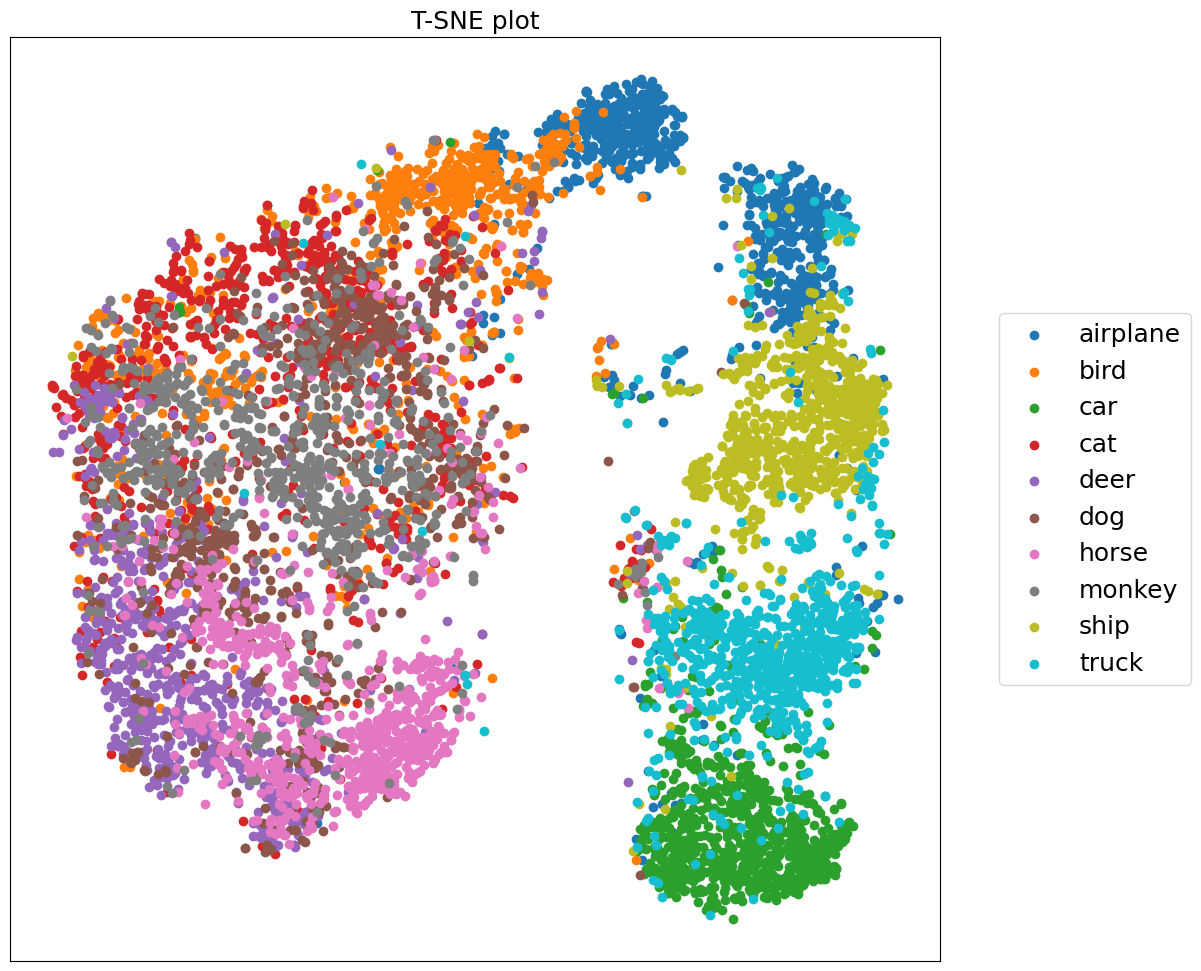

In [18]:
### START CODE HERE ### (>10 line of code)
# Generate features
transf = T.Compose([
                T.ToTensor(),
                T.Resize(config.img_size),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
model = ResNetSimCLR(embedding_size=config.embedding_size)
model = load_model(model, "best_model_min_train_loss.pth")
encoder = model.backbone
train_dl, val_dl = load_data(batch_size=512, train_split="train", transf=transf)
train_feats, train_labels = get_features(encoder, train_dl, config.device)
val_feats, val_labels = get_features(encoder, val_dl, config.device)
torch.save(train_feats, "train_feats.pth")
torch.save(val_feats, "val_feats.pth")
torch.save(train_labels, "train_labels.pth")
torch.save(val_labels, "val_labels.pth")

# Linear evaluation
train_dataset = torch.utils.data.TensorDataset(torch.load("train_feats.pth"), torch.load("train_labels.pth"))
val_dataset = torch.utils.data.TensorDataset(torch.load("val_feats.pth"), torch.load("val_labels.pth"))
train_feat_dl = torch.utils.data.DataLoader(train_dataset, batch_size=512, shuffle=True)
val_feat_dl = torch.utils.data.DataLoader(val_dataset, batch_size=512, shuffle=False)
criterion = nn.CrossEntropyLoss()
classifier = nn.Linear(512, 10)
optimizer = Adam(classifier.parameters(), lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dict_log = linear_eval(classifier, optimizer, 200, train_feat_dl, val_feat_dl, device)

# TSNE plot
val_feats, val_labels = torch.load("val_feats.pth"), torch.load("val_labels.pth")
class_names = torchvision.datasets.STL10(root='~/data').classes
tsne_plot_embeddings(val_feats, val_labels, class_names)
### END CODE HERE ###

### Expected results
Final loss ~5.5

![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week04/figs/tsne_plot_embeddings.png)

# Task 7: Fine-tune on downstream task: supervised image classification on STL10 train split

Variants to be tested: 
- SimCLR weights trained for at least 50 epochs
- Imagenet initialization
- random initialization

Afterwards, print the best val. accuracy for all 3 models!



In [26]:
def finetune(mode='simclr'):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    ### START CODE HERE ### (>10 lines of code)
    plain_transform = T.Compose([
                T.ToTensor(),
                T.Resize(64),
                T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    train_dl, val_dl = load_data(batch_size=128, train_split="train", transf=plain_transform)
    head = nn.Linear(512, 10)
    if mode == 'random':
        model = torchvision.models.resnet18(weights=None)
        model.fc = head
    elif mode == 'imagenet':
        model = torchvision.models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = head
    elif mode == 'simclr':
        model_arch = torchvision.models.resnet18(weights=None)
        model_ssl = ResNetSimCLR(embedding_size=config.embedding_size)
        model_ssl = load_model(model_ssl, './best_model_min_train_loss.pth')
        model = model_ssl.backbone
        model.fc = head
    
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    ### END CODE HERE ###
    dict_log = linear_eval(model, optimizer, 10, train_dl, val_dl, device)
    return dict_log

dict_log_simclr = finetune('simclr')
acc1 = np.max(dict_log_simclr["val_acc_epoch"])
dict_log_in = finetune('imagenet')
acc2 = np.max(dict_log_in["val_acc_epoch"])
dict_log_ran = finetune('random')
acc3 = np.max(dict_log_ran["val_acc_epoch"])
print(f"Fine-tuning best results: SimCLR: {acc1:.2f}%, ImageNet: {acc2:.2f} %, Random: {acc3:.2f} %")

Files already downloaded and verified
Files already downloaded and verified
Model ./best_model_min_train_loss.pth is loaded from epoch 59 , loss 5.431117170284956
Init Accuracy of the model: Train:10.437 	 Val:9.564012


Ep 9/10: Accuracy : Train:98.64 	 Val:62.63 || Loss: Train 0.045 	 Val 1.784: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:14<00:00,  7.42s/it]


Files already downloaded and verified
Files already downloaded and verified
Init Accuracy of the model: Train:12.380 	 Val:11.958165


Ep 9/10: Accuracy : Train:96.90 	 Val:69.23 || Loss: Train 0.086 	 Val 1.766: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:55<00:00,  5.53s/it]


Files already downloaded and verified
Files already downloaded and verified
Init Accuracy of the model: Train:9.996 	 Val:9.954637


Ep 9/10: Accuracy : Train:93.31 	 Val:48.94 || Loss: Train 0.195 	 Val 2.291: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:56<00:00,  5.61s/it]

Fine-tuning best results: SimCLR: 67.87%, ImageNet: 74.21 %, Random: 48.94 %


### Expected results

By fine-tuning all variants for 20 epochs this is what we got: 


```
Fine-tuning best results: SimCLR: 67.87%, ImageNet: 74.21 %, Random: 48.94 %
```

# Task 8:Plot the val accuracies for the 3 different initializations

Plot is left intentionally to cross-check you results qualitatively



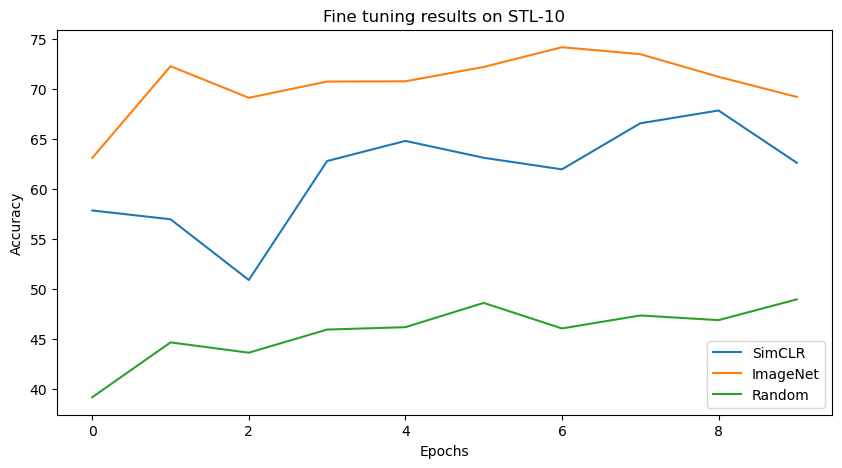

In [27]:
plt.figure(figsize=(10, 5))
plt.plot(dict_log_simclr["val_acc_epoch"], label="SimCLR")
plt.plot(dict_log_in["val_acc_epoch"], label="ImageNet")
plt.plot(dict_log_ran["val_acc_epoch"], label="Random")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Fine tuning results on STL-10")
plt.savefig("fine_tuning_results_stl10.png")
plt.show()

### Expected result
![](https://raw.githubusercontent.com/HHU-MMBS/RepresentationLearning_PUBLIC_2024/main/exercises/week04/figs/fine_tuning_results_stl10.png)

# Conclusion and Bonus reads

That's the end of this exercise. If you reached this point, congratulations!


### Optional stuff

- Improve SimCLR. Add the [LARS optimizer](https://gist.github.com/black0017/3766fc7c62bdd274df664f8ec03715a2) with linear warm + [cosine scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.CosineAnnealingLR.html?highlight=cosine%20scheduler#torch.optim.lr_scheduler.CosineAnnealingLR) + train for 200 epochs. Then make a new comparison!
- Train on CIFAR100 and compare rotation prediction VS SimCLR pretraining on both datasets. Which pretext task is likely to work better there?